# Cryptocurrency Visualization
## Frederik Bussler

#### Import dependencies

In [1]:
import pandas as pd # read JSON price data into DataFrames
import numpy as np # computing, ranges
import matplotlib.pyplot as plt # plotting
import matplotlib
import statsmodels.api as sm # regression
import seaborn as sns # heatmaps
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### Grab BTC_ETH (high volatility, volume, and long history) pair data and normalize

In [2]:
# data every 300 sec (5 minutes) since start (UNIX timestamp 1508441647 would be 1 year)
df = pd.read_json('https://poloniex.com/public?command=returnChartData&currencyPair=BTC_ETH&end=9999999999&period=300&start=0')
df.set_index('date', inplace=True) # set first column of 0,1,2.. default to date inplace (date makes more sense than int index)
df.to_csv('BTC_ETH.csv') # turn into a csv
# divide whole df by first row (normalise) so that the first entry is 1 for all currencies and subsequent cells are pct gains
normalized_closing = df['close'].divide(df['close'].iloc[0])

In [3]:
df.head(1)

,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2015-08-08 05:10:00,0.009,0.33,0.009,0.33,1033.260761,10.654961,0.010312


## Optimise strategy based on SMA crossover for 330,000% returns

If lead (green) is above lag (red) by a certain threshold (around 2.5%) BUY.

If lag (red) is above lead (green) by a certain threshold (around 2.5%) SELL. 

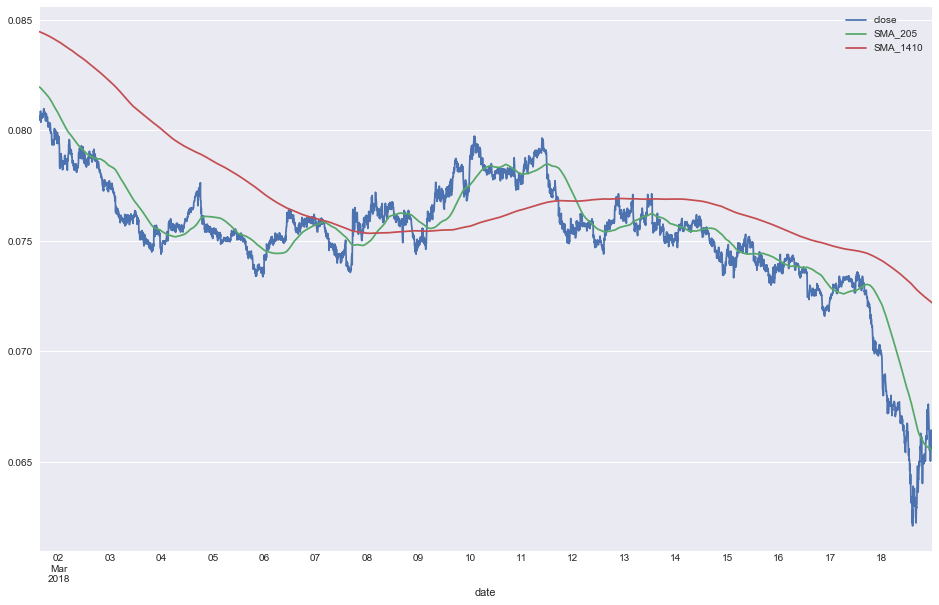

In [5]:
df['SMA_205'] = df['close'].rolling(205).mean() # (LEADING) FAST - shorter lookback
df['SMA_1410'] = df['close'].rolling(1410).mean() # (LAGGING) SLOW - longer lookback
df[['close','SMA_205','SMA_1410']][-5000:].plot(figsize = (16,10))

### Bollinger Bands define prevailing high and low prices. Note volatility.

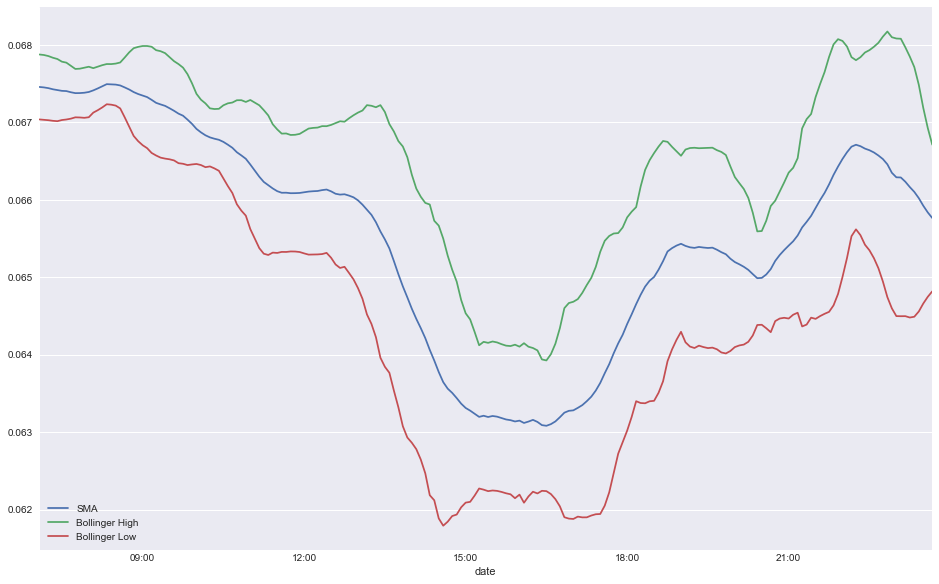

In [6]:
# roll of window for mean is an SMA of 20 periods of 5 minutes
SMA = df['close'].rolling(20).mean()
# roll of window for standard deviation is an SMA of 20 periods
moving_std = df['close'].rolling(20).std()

#create two new DataFrame columns to hold values of upper and lower Bollinger bands
new_df = pd.DataFrame()
new_df['SMA'] = SMA.dropna()
new_df['Bollinger High'] = (SMA + (moving_std * 2)).dropna() # calc, "2" for 2 std's above SMA
new_df['Bollinger Low'] = (SMA - (moving_std * 2)).dropna() # calc 2 std's below SMA
new_df[['SMA','Bollinger High','Bollinger Low']][-200:].plot(figsize=(16,10)) # plot all recently

### Commodity Channel Index warns of overbuying (above 100) and overselling (bellow -100). Note volatility.

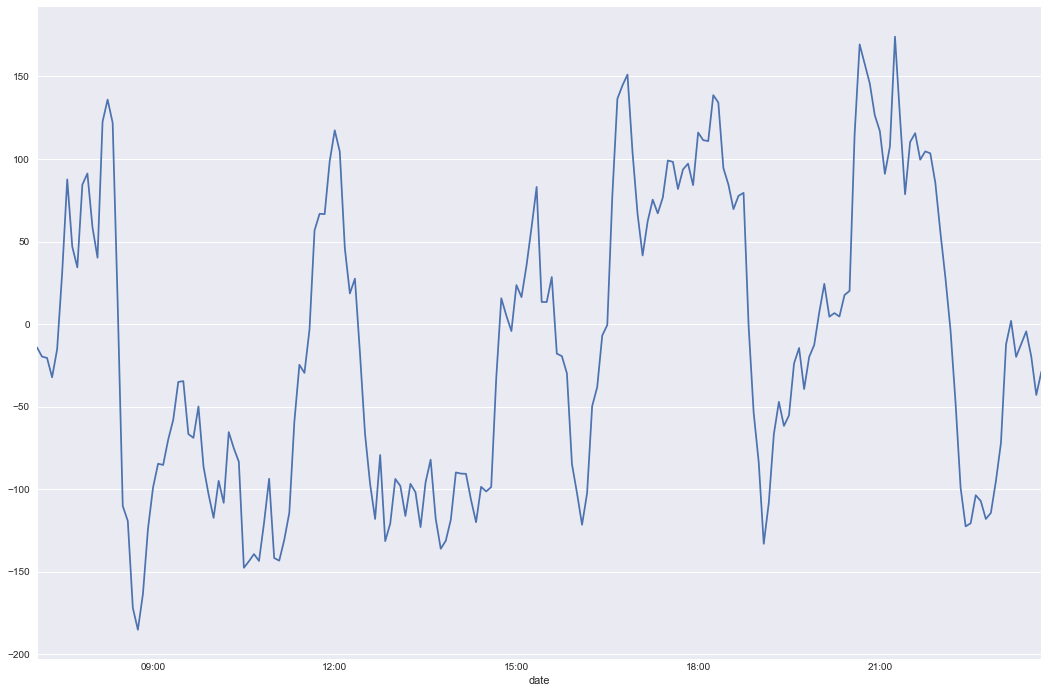

In [7]:
typ_price = (df['high'] + df['low'] + df['close']) / 3 
commodity_channel_index = pd.Series((typ_price - typ_price.rolling(20).mean()) / (0.015 * typ_price.rolling(20).std()))
commodity_channel_index[-200:].plot(figsize=(18,12))

### Candlestick Chart for Past 30 Periods

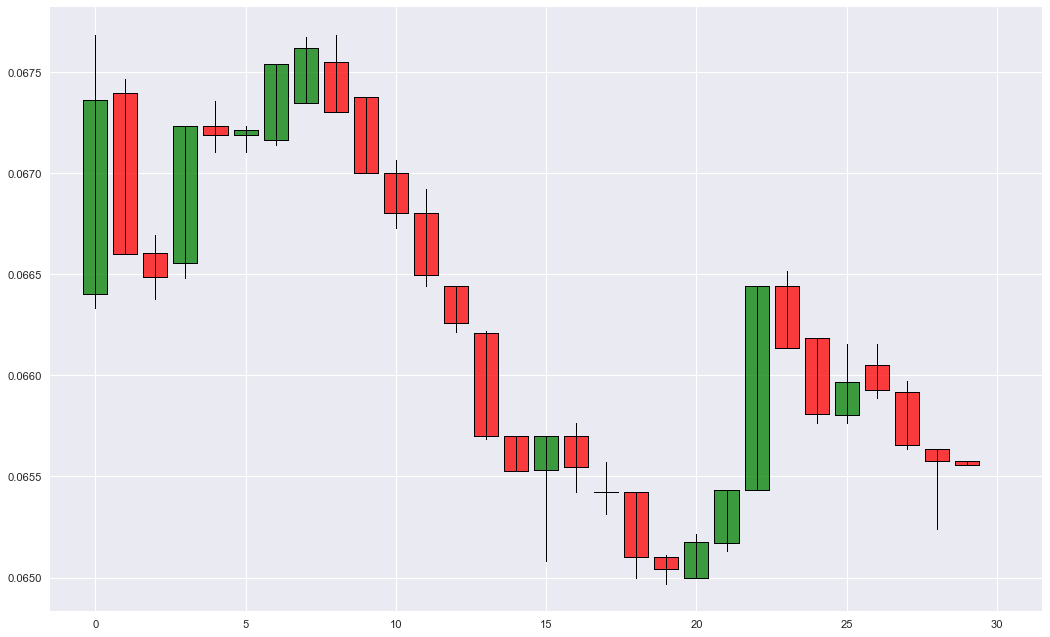

In [8]:
plt.figure(figsize=(16, 10), dpi=80)
opens = df['open'][-30::]
closes = df['close'][-30::]
highs = df['high'][-30::]
lows = df['low'][-30::]
ax = plt.gca()
candle_stick = matplotlib.finance.candlestick2_ochl(ax, opens, closes, highs, lows, width=.8, colorup='g', colordown='r')

### Visualize and test strategy

In [9]:
def test_moving_avg(df, leading, lagging, threshold = 0.02498): # 0.02498 acquired through trial & error (zooming in closer and closer)
    moving_avg = df.copy() # make a copy of df we take as input
    moving_avg['lead'] = moving_avg['close'].rolling(leading).mean() # define lead SMA
    moving_avg['lag'] = moving_avg['close'].rolling(lagging).mean() # define lag SMA
    moving_avg.dropna(inplace = True) # drop NaN vals
    
    # get percent difference of lead-lag
    moving_avg['pc_diff'] = (moving_avg['lead'] - moving_avg['lag']) / moving_avg['close']

    # if percent difference of lead-lag is greater than threshold, BUY!, else neutral
    moving_avg['regime'] = np.where(moving_avg['pc_diff'] > threshold, 1, 0)
    # if percent difference of lead-lag is less than negative of threshold, SELL!, else recurse
    moving_avg['regime'] = np.where(moving_avg['pc_diff'] < -threshold, -1, moving_avg['regime'])

    moving_avg['Market'] = np.log(moving_avg['close'] / moving_avg['close'].shift(1))
    moving_avg['Strat'] = moving_avg['regime'].shift(1) * moving_avg['Market']
    moving_avg[['Market','Strat']] = moving_avg[['Market','Strat']].cumsum().apply(np.exp)

    return moving_avg

In [10]:
moving_avg = test_moving_avg(df, 205, 1410).dropna() # these 2 vals acquired through extensive testing

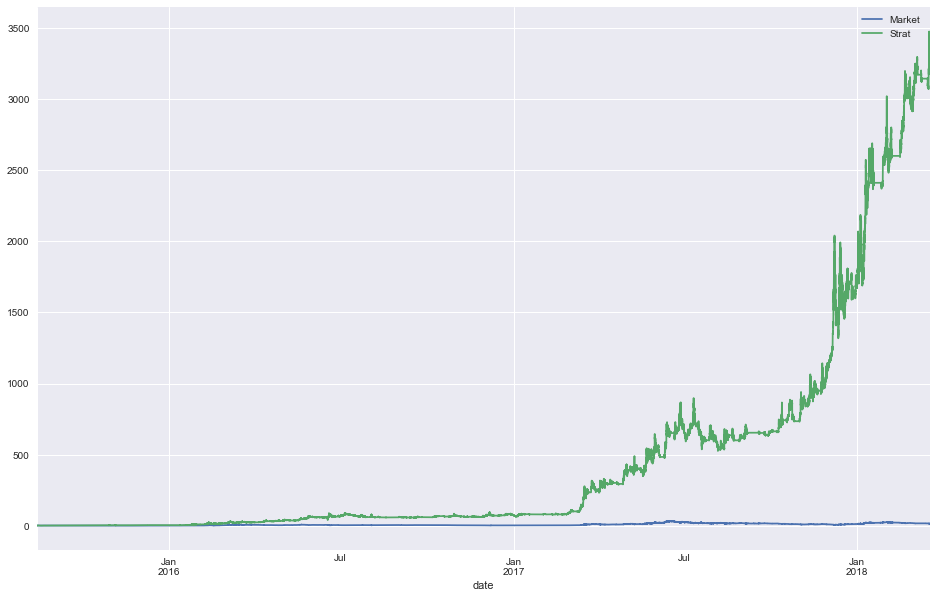

In [11]:
moving_avg[['Market','Strat']][:].plot(figsize = (16,10))

## Discover profit and loss values 

In [12]:
leading, lagging = np.arange(205, 210, 1), np.arange(1410, 1420, 1) # this range acquired through testing
lead_lags = [[lead,lag] for lead in leading for lag in lagging]
profit_and_loss = pd.DataFrame(index=lagging,columns = leading)
for lead, lag in lead_lags:
    profit_and_loss[lead][lag] = test_moving_avg(df, lead, lag)['Strat'][-1]

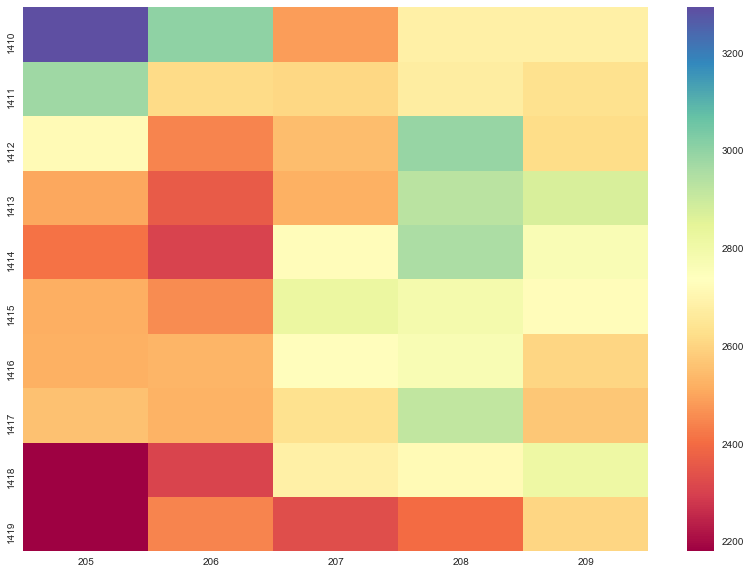

In [13]:
PNL_values = profit_and_loss[profit_and_loss.columns].astype(float)
plt.subplots(figsize = (14,10))
sns.heatmap(PNL_values,cmap='Spectral')

In [14]:
PNL_values[205][1410]*100 # Yield ~330,000% gains

329375.87747502688